In [ ]:
!pip install git+https://github.com/whiteroomlz/mst-clustering.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/whiteroomlz/mst-clustering.git to /tmp/pip-req-build-7x8xkd8h
  Running command git clone --filter=blob:none --quiet https://github.com/whiteroomlz/mst-clustering.git /tmp/pip-req-build-7x8xkd8h
  Resolved https://github.com/whiteroomlz/mst-clustering.git to commit e0d7ca22192a453c535fa9776b641291ffeeba83
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pdb
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform, euclidean
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations, product
from sklearn.datasets import make_blobs
from collections import defaultdict
from sklearn.cluster import DBSCAN
from scipy.special import gamma
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
from math import log

from mst_clustering.clustering_models import ZahnModel, GathGevaModel
from mst_clustering import Pipeline

sns.set_style('whitegrid')

warnings.filterwarnings("ignore")

In [ ]:
n_clusters=3
n_samples=2000
random_seed = 8

well_separated = make_blobs(n_samples=n_samples, centers=n_clusters, random_state=random_seed)

well_separated_noise_ = make_blobs(n_samples=n_samples-400, centers=n_clusters, random_state=random_seed)
well_separated_noise = (
    np.vstack(
    (
        well_separated_noise_[0], 
        np.random.uniform(well_separated_noise_[0].min(), well_separated_noise_[0].max(), (400, 2))
    )
    ),
    np.concatenate([well_separated_noise_[1], [-1] * 400])
)

diff_density = make_blobs(n_samples=[50, 100, 850], n_features=2, centers=[(-8,-4), (-4,2), (-1,-2)], 
                          random_state=random_seed)

skewed_dist = make_blobs(n_samples=n_samples, centers=[(-8,-4), (-4,2), (1,-2)], cluster_std=[1, 0.3, 2],
                             random_state=random_seed)

subclusters = make_blobs(n_samples=n_samples, centers=[(-5,-10), (-5,-5), (7,12), (7,5), (12,-12)], 
                         random_state=random_seed)

t4_8k = (np.array(pd.read_csv('t4.8k.txt', sep=' ', header=None).sample(1500)), None)

datasets = list(zip(
    [well_separated, well_separated_noise, diff_density, skewed_dist, subclusters, t4_8k], 
    ['Well-separated', 'Well-separated + noise', 'Different density', 'Skewed distr.', 'Subclusters', 'T4.8k']
))

In [ ]:
multiprocessing.freeze_support()

mst_clustering = []
for (X, _), _ in tqdm(datasets, desc="MST Zahn's clustering..."):
    clustering = Pipeline(clustering_models=[
        ZahnModel(cutting_condition=20, max_num_of_clusters=50, hv_condition=1e-2, use_additional_criterion=False),
    ])
    clustering.fit(data=X, workers_count=6)
    mst_clustering.append((X, clustering))
    
fuzzy_mst_clustering = []
for (X, _), _ in tqdm(datasets, desc="Fuzzy MST Gath-Geva clustering..."):
    clustering = Pipeline(clustering_models=[
        ZahnModel(cutting_condition=20, max_num_of_clusters=50, hv_condition=1e-2, use_additional_criterion=False),
        GathGevaModel()
    ])
    clustering.fit(data=X, workers_count=6)
    fuzzy_mst_clustering.append((X, clustering))

Fuzzy MST Gath-Geva clustering...: 100%|████████████████████| 6/6 [02:40<00:00, 26.76s/it]


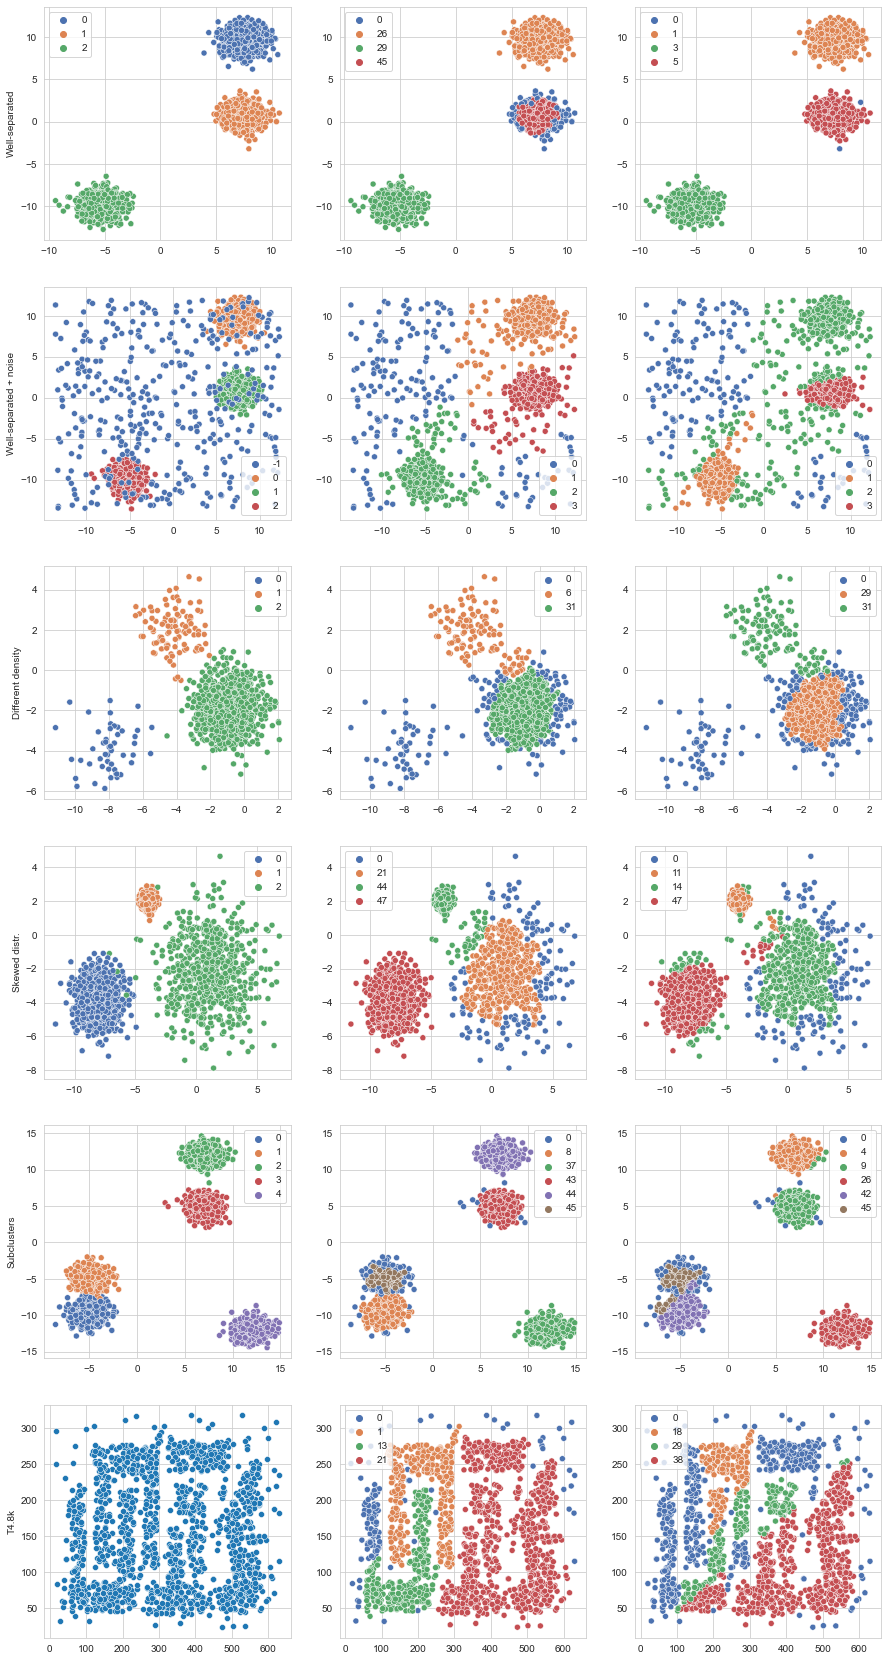

In [ ]:
fig,axs = plt.subplots(len(datasets), 3, figsize=(15, 30))
for index, (((X, y), name), (_, mst), (_, mst_fuzzy)) in enumerate(zip(datasets, mst_clustering, fuzzy_mst_clustering)): 
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=axs[index][0], legend='full', palette='deep')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=mst.labels, ax=axs[index][1], palette='deep')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=mst_fuzzy.labels, ax=axs[index][2], palette='deep')
    axs[index][0].set(ylabel=name)